### **cuFOLIO: Portfolio Optimization on GPU**

This tutorial explores portfolio optimization techniques using the `cuOpt` solver on GPU.

### **Introduction**
This tutorial explores **GPU-accelerated portfolio optimization** using **Conditional Value at Risk (CVaR)**.

1.  **Portfolio Optimization Setup** – Import necessary libraries and configure solver settings.
2.  **Solving Optimization on GPU** – Define optimization parameters and execute on GPU.
3.  **Constructing the Efficient Frontier** – Visualize optimal risk-return portfolios.
4.  **Comparing CPU and GPU Performance** – Evaluate performance solving optimization problem on GPU vs CPU.

#### **Importing Required Libraries & Initial Setup**

Before diving into portfolio optimization, we need to import the necessary libraries and perform initial setup if required.

In [ ]:
# Install dependencies
# This cell only needs to be run once, typically after setting up the environment.
# If dependencies are already installed, you can comment out or skip this cell.

# Install cuOpt (if not already installed)
# !pip install --user --extra-index-url https://pypi.nvidia.com -q cuopt-cu12==25.5.*

# Install other dependencies (if not already installed)
# !pip install --user --extra-index-url https://pypi.nvidia.com -q "numpy>=1.24.4" "pandas>=2.2.1" "cvxpy>=1.6.5" "scipy==1.15.2" "scikit-learn==1.6.1" "msgpack>=1.1.0" "cuml-cu12==25.4.*" "seaborn>=0.13.2" bin/cufolio-25.5-py3-none-any.whl

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

# Optimization and numerical computation libraries
from cufolio import cvar_optimizer, cvar_utils
import cvxpy as cp
from cuopt import linear_programming
from cuopt.linear_programming.solver_settings import PDLPSolverMode
from cuopt.linear_programming.solver.solver_parameters import *

In [2]:
# --- Global GPU Solver Settings ---
# Initialize GPU solver settings once for the notebook
# These settings will be used for all GPU-based optimizations.
gpu_solver_settings = linear_programming.SolverSettings()
gpu_solver_settings.set_parameter(CUOPT_PDLP_SOLVER_MODE, PDLPSolverMode.Stable2)
gpu_solver_settings.set_optimality_tolerance(1e-4)              # Define optimality tolerance (default: 1e-4)
gpu_solver_settings.set_parameter(CUOPT_TIME_LIMIT, 10)         # Set time limit for the solver to 10 seconds
gpu_solver_settings.set_parameter(CUOPT_LOG_TO_CONSOLE, False)  # Disable log to console

In [3]:
# --- Predefined Market Scenarios ---
# This dictionary defines various market scenarios with their respective start and end dates.
# These can be selected by their key name in the subsequent sections.
MARKET_SCENARIOS = {
    'pre_crisis':      ('2005-01-01', '2007-10-01'),
    'crisis':          ('2007-10-01', '2009-04-01'),
    'post_crisis':     ('2009-06-30', '2014-06-30'),
    'oil_price_crash': ('2014-06-01', '2016-03-01'),
    'FAANG_surge':     ('2015-01-01', '2021-01-01'),
    'covid':           ('2020-01-01', '2023-01-01'),
    'recent':          ('2022-01-01', '2024-07-01')
}

# Helper function to retrieve date ranges for a given market scenario
def get_market_period(name: str) -> tuple[str, str]:
    """Return (start_date, end_date) for a given scenario name."""
    try:
        return MARKET_SCENARIOS[name]
    except KeyError:
        valid_scenarios = ", ".join(MARKET_SCENARIOS.keys())
        raise ValueError(f"Unknown scenario '{name}'. Choose from: {valid_scenarios}")

#### **0. Formulation of the Optimization Problem**

Mean-CVaR optimization can be formulated as follows:

$$
\begin{align}
\text{max: } & \mu^T \mathbf{w} - \lambda_{risk}\left(t + \frac{1}{1-\alpha}\mathbf{p}^T \mathbf{u}\right)\\\
\text{subject to: } & \mathbf{1}^T \mathbf{w} = 1\\
& \mathbf{u} \geq -R^T \mathbf{w} - t\\
& \mathbf{w}^{\min} \leq \mathbf{w} \leq \mathbf{w}^{\max}, c^{\min} \leq c \leq c^{\max},\\
& L= \Vert \mathbf{w} \Vert_1 \leq L^{tar}
\end{align}
$$

All problem-related constants in the objective and constraints should be included in the `CVaR_Parameters` object (`cvar_params`).

##### Additional Supported Constraints
We support two additional types of constraints:

1.  **CVaR Limit**: Set a strict upper bound on the Conditional Value-at-Risk (CVaR).
    * **How to use**: Specify `cvar_limit` in `cvar_params`.
2.  **Turnover Constraint**: Restrict portfolio turnover by limiting deviations from an existing portfolio.
    * **How to use**: Provide an existing portfolio as a `Portfolio` object and set `T_tar` in `cvar_params`.

#### **1. Instantiate Parameters and Optimizer Objects (S&P 500 Example)**

In this section, we define the parameters for Conditional Value-at-Risk (CVaR) optimization for an S&P 500 dataset example and initialize the optimizer.

##### 1.1 Define CVaR Parameters for S&P 500 Example

The `CVaR_Parameters` object encapsulates key constraints and settings for portfolio optimization.

**Parameters Explanation:**
-   **Portfolio Constraints:**
    * `w_min`, `w_max`: Minimum and maximum asset weights.
    * `c_min`, `c_max`: Minimum and maximum cash holdings.
    * `L_tar`: Leverage target, restricting the total long/short positions.
-   **Risk Constraints:**
    * `risk_aversion`: Penalization factor for risk (higher values prioritize lower risk).
    * `confidence`: The percentile (e.g., 0.95) beyond which the average loss (CVaR) is computed.
    * `num_scen`: Number of simulated return scenarios.
-   **Optional Constraints:**
    * `T_tar`: Turnover constraint (None in this initial example).
    * `cvar_limit`: Strict constraint on CVaR (None in this initial example).
-   **Fitting Method:**
    * `fit_type`: Method for return distribution estimation (`'kde'`, `'gaussian'`, `'historical'`).

In [4]:
# Define CVaR optimization parameters for the S&P 500 example
sp500_cvar_params = cvar_optimizer.CVaR_Parameters(
    w_min=-0.3, w_max=0.8,        # Asset weight allocation bounds
    c_min=0.1, c_max=0.4,         # Cash holdings bounds
    L_tar=1.6, T_tar=None,        # Leverage & Turnover (None for this example)
    cvar_limit=None,              # Max CVaR (None = unconstrained for this example)
    risk_aversion=0.5,            # Risk aversion level
    confidence=0.95,              # CVaR confidence level (alpha)
    num_scen=10000,               # Number of return scenarios to simulate
    fit_type="kde"                # Return distribution estimation method
)

##### 1.2 Load Returns Data for S&P 500 Example

We construct a **returns dictionary** for the S&P 500 dataset.

**Key Components:**
-   **Return Type (`return_type`)**: `'LOG'` for log-returns.
-   **Historical Dataset (`dataset_path`)**: CSV file with adjusted closing prices.
-   **Regime Information (`regime_dict`)**: Defines the market regime for analysis.
-   **Scenario Modeling**: Returns are computed, potentially using KDE on CPU or GPU.

In [5]:
# --- User inputs for S&P 500 Example ---
sp500_dataset_name = "sp500"
sp500_scenario_key = "recent"  # Choose a key from MARKET_SCENARIOS
sp500_return_type = "LOG"
sp500_kde_device = "GPU"       # Device for KDE computation ("GPU" or "CPU")

# Get date range and file path
sp500_start_date, sp500_end_date = get_market_period(sp500_scenario_key)
sp500_data_path = f"../data/stock_data/{sp500_dataset_name}.csv"

# Define the regime for this example
sp500_regime_dict = {"name": sp500_scenario_key, "range": (sp500_start_date, sp500_end_date)}

# Compute returns for the S&P 500 example
sp500_returns_dict = cvar_utils.calculate_returns(
    sp500_data_path,
    sp500_regime_dict,
    sp500_return_type,
    sp500_cvar_params,         # CVaR parameters defined for this example
    device=sp500_kde_device
)

##### 1.3 Instantiate the CVaR Optimizer for S&P 500 Example
Create the CVaR optimizer object using the computed returns and parameters for the S&P 500 data.

In [6]:
# Instantiate CVaR optimization problem for the S&P 500 example
sp500_cvar_problem = cvar_optimizer.CVaR(
    returns_dict=sp500_returns_dict,
    cvar_params=sp500_cvar_params
)

#### **2. Solve the Optimization Problem on GPU (S&P 500 Example)**

##### 2.1 Solve the CVaR Optimization Problem
Using the globally defined `gpu_solver_settings`.

In [7]:
# Solve the optimization problem using the configured GPU solver settings
# The solve_optimization_problem method will print the results.
sp500_opt_result_series, sp500_optimal_portfolio = sp500_cvar_problem.solve_optimization_problem(
   device="GPU",
   gpu_settings=gpu_solver_settings # Using global GPU solver settings
)

*************************
--- GPU CVaR Results---
recent: ('2022-01-01', '2024-07-01')
Scenarios: 10000
solver time: 0.0003 seconds
IO time: 0.5588 seconds
--- Optimal Portfolio ---
Short--BIO: -0.007
Long--FICO: 0.211
Long--GE: 0.24
Short--ILMN: -0.193
Long--LLY: 0.43
Short--MTCH: -0.3
Long--NVDA: 0.194
Long--VLO: 0.024
cash: 0.4
*************************



##### 2.2 View Optimization Results for S&P 500 Example
The `sp500_opt_result_series` contains key metrics from the optimization. CVaR will be capped if `cvar_limit` was specified in `sp500_cvar_params`.

In [8]:
sp500_opt_result_series

regime          recent
solve time    0.000336
return        0.003079
CVaR          0.027418
obj          -0.002327
dtype: object

##### 2.3 Plot the Optimized Portfolio for S&P 500 Example
Visualize the asset allocation of the optimized portfolio.

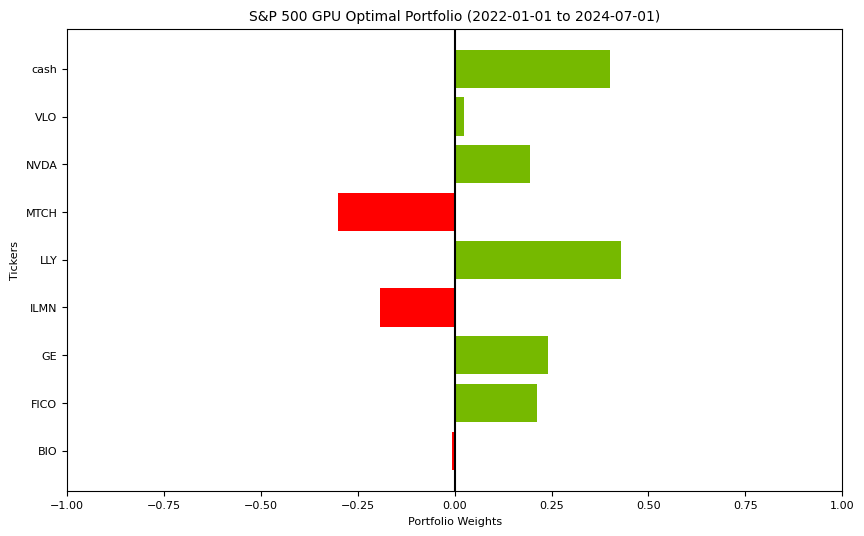

In [9]:
# Ensure sp500_optimal_portfolio is defined from the previous cell
if 'sp500_optimal_portfolio' in globals():
    sp500_optimal_portfolio.plot_portfolio(
        show_plot=True,
        title=f"S&P 500 GPU Optimal Portfolio ({sp500_start_date} to {sp500_end_date})"
    )
else:
    print("sp500_optimal_portfolio is not defined. Please run the optimization cell.")

#### **3. Constructing the Efficient Frontier for Portfolio Optimization**

The efficient frontier represents the set of optimal portfolios offering the highest expected return for a defined risk level or the lowest risk for a given return level.

##### 3.1 Define CVaR Parameters for Efficient Frontier (Global Titans Proxy Example)
For this example, we use different CVaR parameters, such as no shorting and no cash allocation.

In [10]:
# Define CVaR optimization parameters for Efficient Frontier (EF) construction
ef_cvar_params = cvar_optimizer.CVaR_Parameters(
    w_min=0, w_max=1,             # Asset weight bounds (no shorting)
    c_min=0, c_max=0,             # Cash holdings bounds (no cash allocation)
    L_tar=1.0,                    # Leverage target (fully invested, sum of weights = 1 for long only)
    T_tar=None,                   # No turnover constraint
    cvar_limit=None,              # Max CVaR (unconstrained)
    risk_aversion=1,              # Base risk aversion (will be varied to generate EF)
    confidence=0.95,              # CVaR confidence level
    num_scen=10000,               # Number of return scenarios
    fit_type="gaussian"           # Return distribution estimation method
)

##### 3.2 Prepare Market Data for Efficient Frontier (Global Titans Proxy Example)
We use the "global_titans_proxy" dataset for constructing the efficient frontier.

In [11]:
# --- User inputs for Efficient Frontier (EF) Example ---
ef_scenario_key = "recent"  # Choose a key from MARKET_SCENARIOS
ef_dataset_name = "global_titans_proxy"
ef_return_type = "LOG"
ef_kde_device = "GPU"

# Get date range and file path
ef_start_date, ef_end_date = get_market_period(ef_scenario_key)
ef_regime_dict = {"name": ef_scenario_key, "range": (ef_start_date, ef_end_date)}
ef_dataset_path = f"../data/stock_data/{ef_dataset_name}.csv"

# Compute returns for EF
ef_returns_dict = cvar_utils.calculate_returns(
    ef_dataset_path,
    ef_regime_dict,
    ef_return_type,
    ef_cvar_params,         # CVaR parameters for EF
    device=ef_kde_device
)

##### 3.3 Define Efficient Frontier Parameters
These parameters control the generation and plotting of the efficient frontier.

**Parameters for `generate_efficient_frontier`:**
-   `returns_dict`: Dictionary of returns data.
-   `cvar_params`: Base `CVaR_Parameters` object.
-   `device`: Optimization device (`"GPU"` or `"CPU"`).
-   `gpu_settings`: Solver settings for GPU.
-   `custom_portfolios_dict` (optional): Custom portfolios to plot on the EF.
-   `title`: Plot title.
-   `EF_result_csv_name`, `EF_plot_png_name`: Paths to save results and plot.
-   `min_risk_aversion`, `max_risk_aversion`: Range for the risk aversion parameter (exponent of 10).
-   `ra_num`: Number of risk aversion levels to iterate through.

In [12]:
# --- Efficient Frontier (EF) Settings ---
# Optional: Define custom portfolios to display on the EF plot
ef_custom_portfolios_dict = {
    "NVDA-AMZN portfolio": ({"NVDA": 0.72, "AMZN": 0.18}, 0.1), # ({asset_weights_dict}, cash_holding_float)
    "AAPL-MSFT portfolio": ({"AAPL": 0.29, "NKE": 0.01, "MSFT": 0.6}, 0.1),
}

ef_plot_title = f"Efficient Frontier Plot – {ef_dataset_name} ({ef_scenario_key})"
ef_output_folder = "/tmp/EF_results/" # Folder to save EF results
ef_results_csv_path = os.path.join(ef_output_folder, "EF_results.csv")
ef_plot_png_path = os.path.join(ef_output_folder, "EF_plot.png")

# Range for risk aversion parameter (lambda_risk)
ef_min_risk_aversion_exp = -3         # Corresponds to 1e-3 (high risk appetite)
ef_max_risk_aversion_exp = 1          # Corresponds to 1e1 = 10 (risk-averse)
ef_risk_aversion_steps = 30           # Number of risk aversion levels for a smoother EF

# Prepare output directory
os.makedirs(ef_output_folder, exist_ok=True)

##### 3.4 Run Efficient Frontier Calculation
This process solves multiple optimization problems with varying risk aversion levels and may take some time.

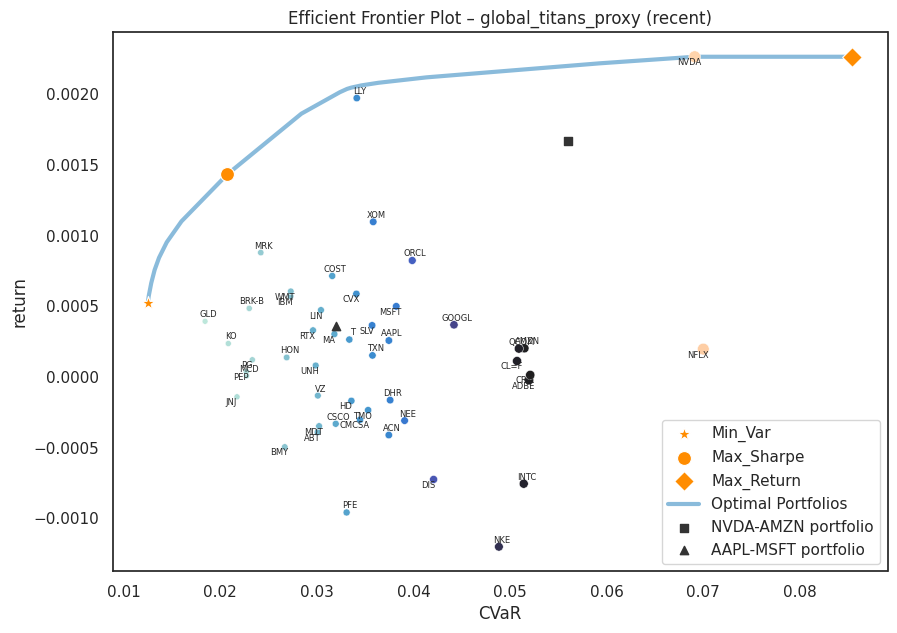

In [13]:
# Generate the efficient frontier
# This function will iterate through different risk aversion levels, 
# solve the CVaR optimization for each, and then plot the frontier.
ef_results_df = cvar_utils.generate_efficient_frontier(
    returns_dict=ef_returns_dict,
    cvar_params=ef_cvar_params,       # Base CVaR params for EF
    device="GPU",
    gpu_settings=gpu_solver_settings, # Global GPU solver settings
    opt_result_verbose=False,         # Suppress individual optimization printouts
    folder_name=None,                 # Not needed if EF_result_csv_name is absolute
    custom_portfolios_dict=ef_custom_portfolios_dict,
    title=ef_plot_title,
    EF_result_csv_name=ef_results_csv_path,
    EF_plot_png_name=ef_plot_png_path,
    show_plot=True,
    min_risk_aversion=ef_min_risk_aversion_exp,
    max_risk_aversion=ef_max_risk_aversion_exp,
    ra_num=ef_risk_aversion_steps
)
# The ef_results_df DataFrame contains the return, CVaR, and portfolio weights for each point on the frontier.

#### **4. Comparing CPU and GPU Optimization Across Market Regimes**

This section compares portfolio optimization performance (solve time and objective value) across different market regimes using both CPU and GPU.
Running with `device="BOTH"` will execute optimizations on both CPU (using CVXPY with a specified solver) and GPU (using cuOpt).
The results aim to highlight the significant acceleration achievable with GPU-based optimization.

In [15]:
# --- User inputs for Regime Comparison ---
regime_comp_dataset_name = "sp500"
# Select a list of scenario keys from MARKET_SCENARIOS for comparison
regime_comp_scenario_keys = ["pre_crisis", "crisis"]
regime_comp_return_type = "LOG"
regime_comp_num_scenarios = 10000 # Number of scenarios for CVaR parameter

# Prepare output directory & file name
regime_comp_output_folder = "/tmp/regime_results"
os.makedirs(regime_comp_output_folder, exist_ok=True)
regime_comp_results_csv_path = os.path.join(
    regime_comp_output_folder,
    f"both_results_{regime_comp_dataset_name}_{regime_comp_num_scenarios}.csv"
)

# Regime settings
regime_comp_selected_dict = {name: get_market_period(name) for name in regime_comp_scenario_keys}
regime_comp_cpu_solver_settings = {"solver": cp.CLARABEL, "verbose": False} # CVXPY solver settings

# CVaR parameters for regime comparison
regime_comp_cvar_params = cvar_optimizer.CVaR_Parameters(
    w_min=-0.3, w_max=0.8,
    c_min=0.1, c_max=0.4,
    L_tar=1.6, T_tar=None,
    cvar_limit=0.04,
    risk_aversion=0.3,
    confidence=0.95,
    num_scen=regime_comp_num_scenarios, # Using the specified number of scenarios
    fit_type="kde"
)

regime_comp_dataset_path = f"../data/stock_data/{regime_comp_dataset_name}.csv"

# Run CPU vs GPU comparison across selected regimes
regime_comparison_results_df = cvar_utils.optimize_market_regimes(
    input_file_name=regime_comp_dataset_path,
    return_type=regime_comp_return_type,
    all_regimes=regime_comp_selected_dict,
    device="BOTH",                    # Compare CPU and GPU
    cpu_settings=regime_comp_cpu_solver_settings,
    gpu_settings=gpu_solver_settings, # Global GPU solver settings
    problem_from_folder=None,
    cvar_params=regime_comp_cvar_params,
    results_csv_file_name=regime_comp_results_csv_path
)

print(f"Regime comparison results saved to: {regime_comp_results_csv_path}")
# The regime_comparison_results_df DataFrame will contain performance metrics for both CPU and GPU.
# The optimize_market_regimes function will print intermediate results for each regime and device.

Solver: CLARABEL
*************************
--- CPU CVaR Results---
pre_crisis: ('2005-01-01', '2007-10-01')
Scenarios: 10000
solver time: 116.4382 seconds
--- Optimal Portfolio ---
Long--AAPL: 0.266
Short--AXON: -0.059
Short--BSX: -0.062
Long--DLR: 0.027
Long--HOLX: 0.061
Long--ILMN: 0.19
Long--ISRG: 0.24
Short--JCI: -0.184
Short--LEN: -0.066
Long--MNST: 0.385
Long--NVDA: 0.034
Short--PHM: -0.027
cash: 0.195
*************************

*************************
--- GPU CVaR Results---
pre_crisis: ('2005-01-01', '2007-10-01')
Scenarios: 10000
solver time: 0.0013 seconds
IO time: 1.3580 seconds
--- Optimal Portfolio ---
Long--AAPL: 0.261
Short--AXON: -0.056
Long--BKNG: 0.005
Short--BSX: -0.055
Long--DLR: 0.036
Long--HOLX: 0.062
Long--ILMN: 0.19
Long--ISRG: 0.223
Short--JCI: -0.197
Short--LEN: -0.053
Long--MNST: 0.395
Long--NVDA: 0.036
Short--PHM: -0.032
cash: 0.186
*************************

Solver: CLARABEL
*************************
--- CPU CVaR Results---
crisis: ('2007-10-01', '2009-04

---
SPDX-FileCopyrightText: Copyright (c) 2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
SPDX-License-Identifier: MIT
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.